In [38]:
import numpy as np
import pandas as pd

In [39]:
import torch

In [40]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt





pth_path = '/kaggle/input/dataset-dataset/eeg_signals_raw_with_mean_std.pth'
loaded_data = torch.load(pth_path)
dataset = loaded_data['dataset']

In [41]:

target_length = 440  # Desired length after trimming
trim_front = 20      # Number of time points to remove from the front

for sample in dataset:
    eeg = sample['eeg']  # shape: (channels, time)

    # Step 1: Trim the first 20 time points
    eeg = eeg[:, trim_front:]

    # Step 2: Truncate or pad to length 440
    current_len = eeg.shape[1]

    if current_len > target_length:
        eeg = eeg[:, :target_length]  # Truncate
    elif current_len < target_length:
        # Pad with zeros at the end (right side)
        pad_size = target_length - current_len
        padding = torch.zeros((eeg.shape[0], pad_size), dtype=eeg.dtype)
        eeg = torch.cat((eeg, padding), dim=1)

    # Update the sample
    sample['eeg'] = eeg

In [42]:
from scipy.signal import butter, filtfilt

In [43]:
def bandpass_filter(eeg_tensor, lowcut, highcut, fs, order=4):
    eeg_np = eeg_tensor.numpy()  # Convert to NumPy for filtering
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    # Apply filter to each channel individually (axis=1 is time)
    filtered = np.array([filtfilt(b, a, ch) for ch in eeg_np])
    return torch.tensor(filtered, dtype=torch.float32)


In [44]:
sampling_rate = 1000  # Hz (change based on your data!)
lowcut = 5
highcut = 95

for sample in dataset:
    eeg = sample['eeg'].float()  # Ensure it's float
    filtered_eeg = bandpass_filter(eeg, lowcut, highcut, sampling_rate)
    sample['eeg'] = filtered_eeg  # Replace with filtered version


In [45]:
def segment_into_epochs(eeg_tensor, epoch_len, step):
    _, total_time = eeg_tensor.shape
    epochs = []
    for start in range(0, total_time - epoch_len + 1, step):
        end = start + epoch_len
        epoch = eeg_tensor[:, start:end]
        epochs.append(epoch)
    return epochs


In [46]:
epoch_len = 100
step = 100

new_dataset = []

for sample in dataset:
    eeg = sample['eeg']
    epochs = segment_into_epochs(eeg, epoch_len, step)

    for epoch in epochs:
        new_sample = {
            'eeg': epoch,
            'label': sample['label'],
            'subject': sample['subject'],
            'image': sample['image']
        }
        new_dataset.append(new_sample)


In [47]:
for sample in new_dataset:
    eeg = sample['eeg'].float()
    mean = eeg.mean()
    std = eeg.std()


    if std > 0:
        eeg = (eeg - mean) / std
    else:
        eeg = eeg - mean

    sample['eeg'] = eeg


In [48]:
target_channels = 128

for sample in new_dataset:
    eeg = sample['eeg']  # shape: (channels, time)
    c, t = eeg.shape

    if c < target_channels:
        reps = target_channels // c
        remainder = target_channels % c

        # Repeat full copies
        repeated = eeg.repeat(reps, 1)  # shape: (c * reps, t)

        # Add remaining channels if needed
        if remainder > 0:
            extra = eeg[:remainder, :]  # slice to fill up
            padded_eeg = torch.cat((repeated, extra), dim=0)
        else:
            padded_eeg = repeated

        sample['eeg'] = padded_eeg

    elif c > target_channels:
        # Truncate extra channels if any (unlikely)
        sample['eeg'] = eeg[:target_channels, :]



In [49]:
import torch.nn as nn

def temporal_tokenize(eeg):

    c, t = eeg.shape
    assert t % 4 == 0

    eeg = eeg.view(c, t // 4, 4)
    eeg = eeg.permute(1, 0, 2)
    tokens = eeg.reshape(eeg.shape[0], -1)
    return tokens


In [50]:
token_embedder = nn.Linear(512, 1024)
for sample in new_dataset:
    eeg = sample['eeg']  # shape: (100, 128)

    tokens = temporal_tokenize(eeg)  # shape: (25, 512)
    embeddings = token_embedder(tokens)  # shape: (25, 1024)

    sample['eeg_tokens'] = embeddings  # or replace 'eeg' if needed


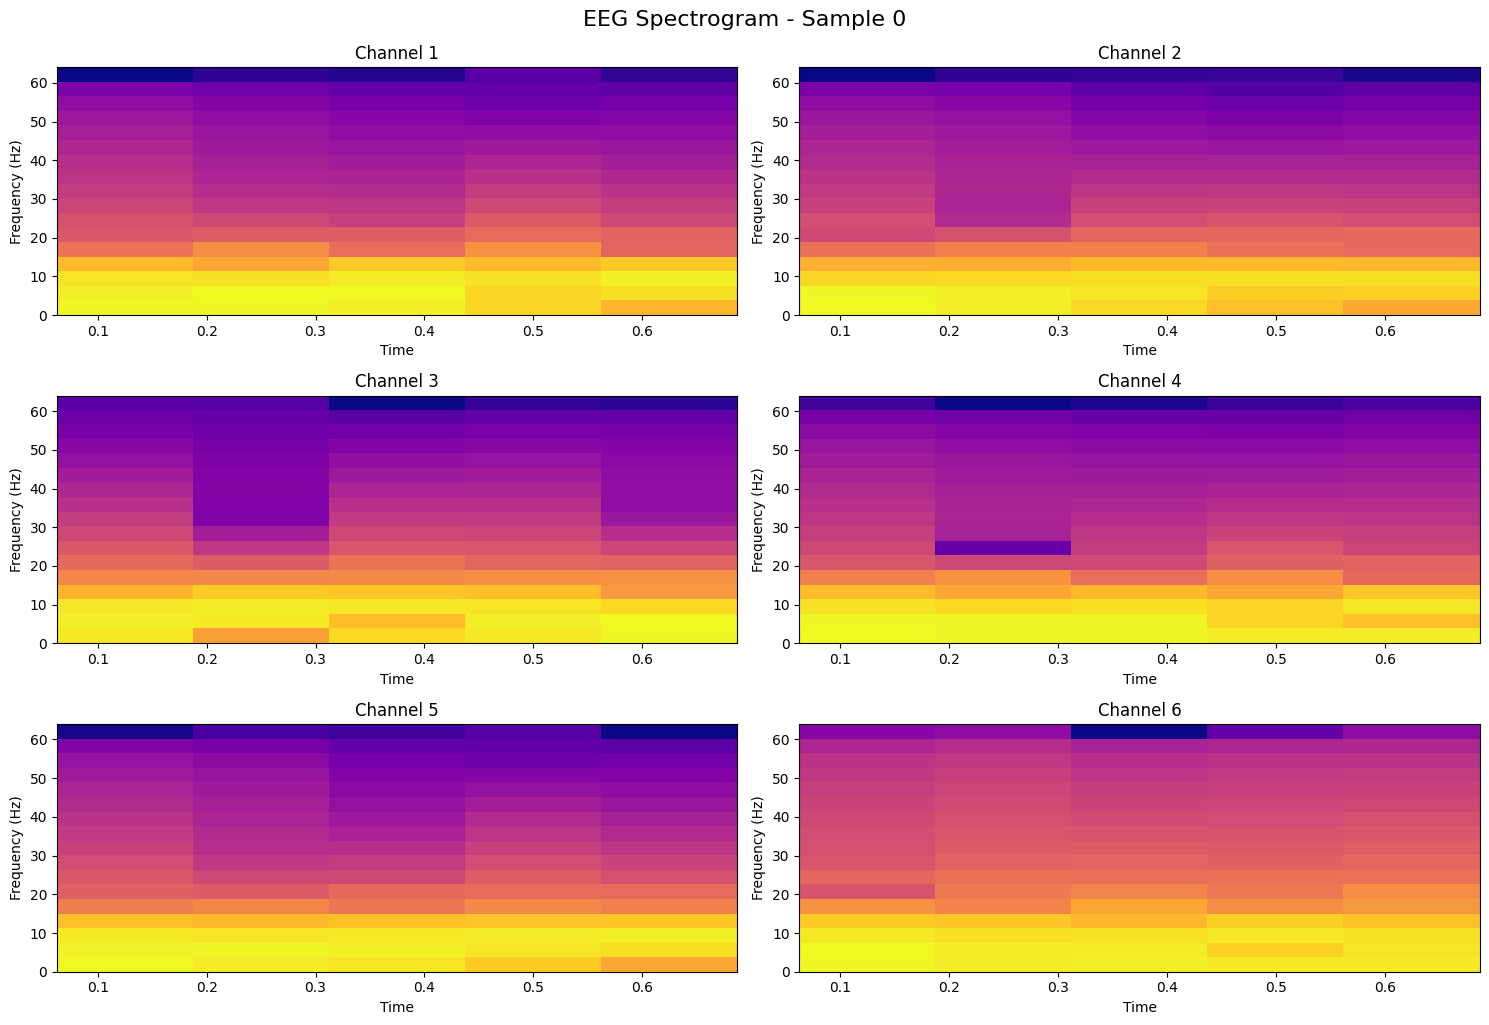

In [51]:

def plot_spectrogram(eeg, sample_idx=0):

    eeg_np = eeg.numpy()

    plt.figure(figsize=(15, 10))

    # Plot spectrogram for a few channels
    for i, ch_data in enumerate(eeg_np[:6]):  # Only show first 6 channels
        plt.subplot(3, 2, i + 1)
        plt.specgram(ch_data, Fs=128, NFFT=32, noverlap=16, cmap='plasma')
        plt.title(f"Channel {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.suptitle(f"EEG Spectrogram - Sample {sample_idx}", fontsize=16, y=1.02)
    plt.show()

# Example usage:
sample = new_dataset[0]  # Pick one EEG sample
plot_spectrogram(sample['eeg'].float())
